## Fonte de dados
Foi selecionada a fonte de dados ["BIRDS 400 - SPECIES IMAGE CLASSIFICATION"](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) que possui um catálogo com 58.388 imagens para treino, 2.000 imagens para teste e 2.000 imagens para validação.
As imagens estão no formato JPG na resolução 224x224 (RGB).

## Dependências

### Linguagens e Ferramentas
- Python 3
- CUDA Toolkit
- cuDNN


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras

In [10]:
class Dataset:
    DATASET_PATH = './dataset/birds'
    IMAGE_WIDTH = 224
    IMAGE_HEIGHT = 224
    
class Labels:
    TRAIN = 'train'
    VALID = 'valid'
    TEST = 'test'
    
class Files:
    TRAIN_PATH = pathlib.Path(Dataset.DATASET_PATH + '/train')
    VALID_PATH = pathlib.Path(Dataset.DATASET_PATH + '/valid')
    TEST_PATH = pathlib.Path(Dataset.DATASET_PATH + '/test')

BATCH_SIZE=32

### Visualização dos arquivos duplicados
_obs: vai parar de funcionar uma vez que os arquivos sejam removidos_

In [ ]:
fig,axes=plt.subplots(nrows=4,ncols=2,figsize=(12,12))

duplicates = [ 'ABBOTTS BABBLER/004.jpg',
              'ABBOTTS BABBLER/005.jpg',
              'PINK ROBIN/007.jpg',
              'ROBIN/95.jpg',
              'BLACK COCKATO/027.jpg',
              'BLACK COCKATO/028.jpg',
              'TASMANIAN HEN/029.jpg',
              'TASMANIAN HEN/097.jpg']

   

for i,ax in enumerate(axes.flat): 
    path = Files.TRAIN_PATH / pathlib.Path(duplicates[i])
    x=plt.imread(path)
    ax.imshow(x)
    ax.set_title(duplicates[i])
plt.tight_layout()    
plt.show() 

### Exploração dos dados

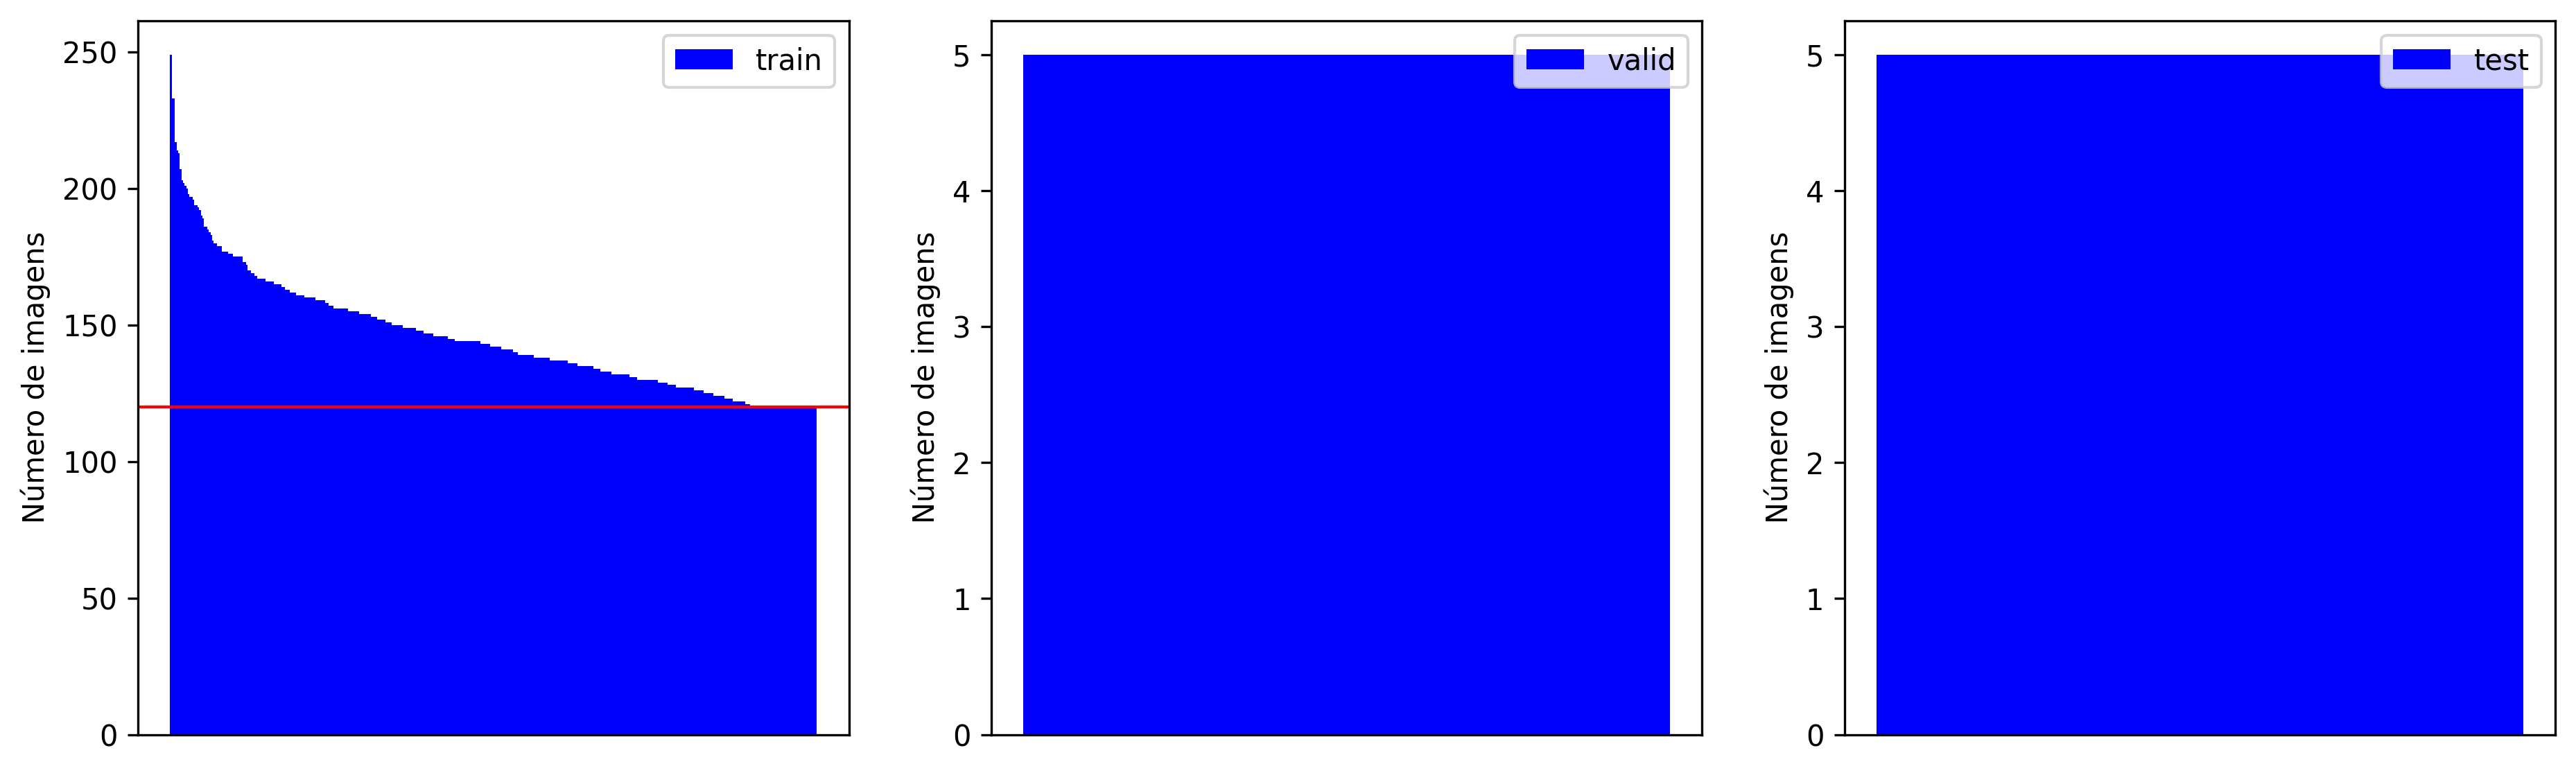

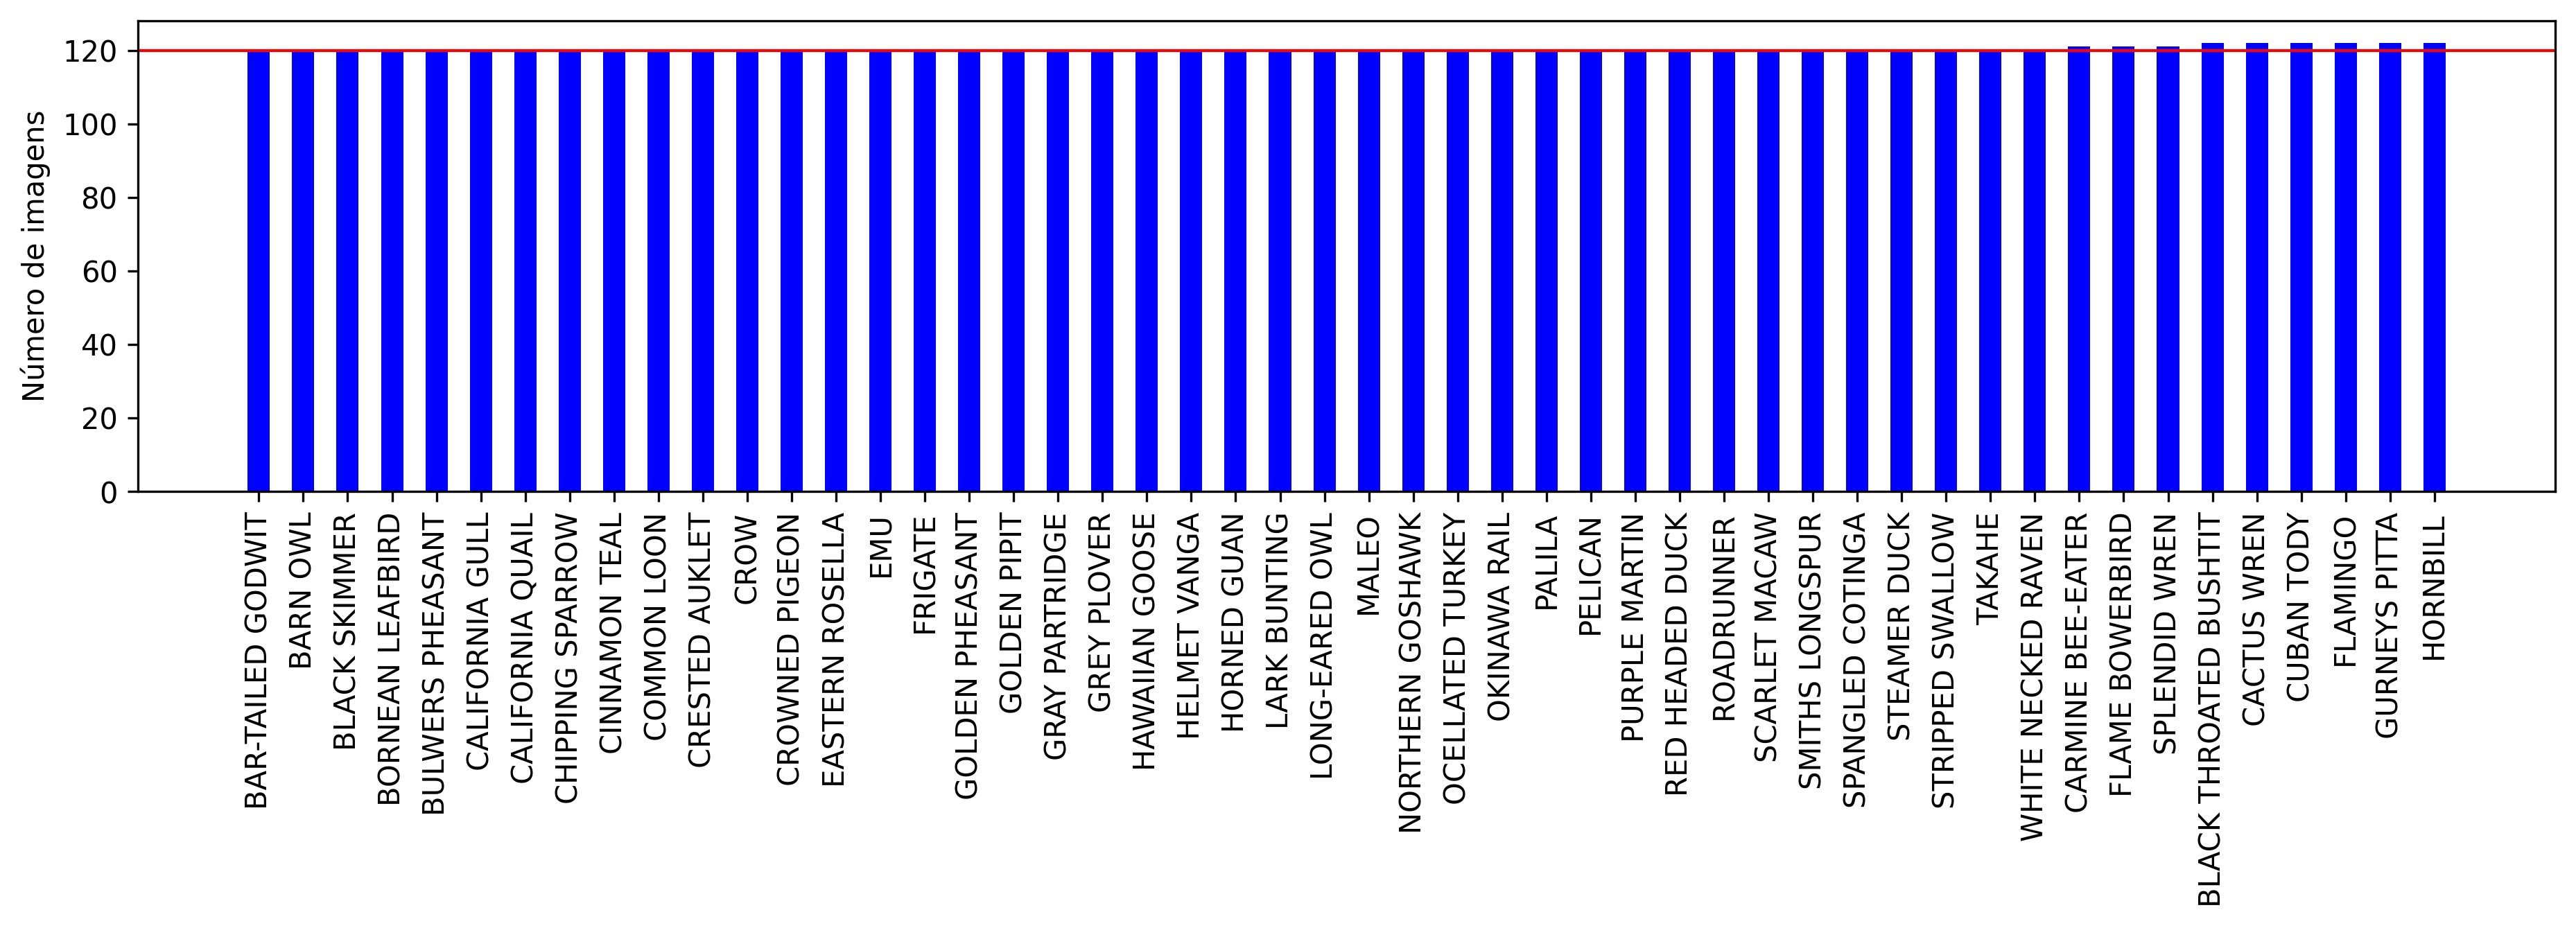

In [74]:
plt.figure(figsize=(15,10), dpi=300)

i = 1
for target_directory in [Files.TRAIN_PATH, Files.VALID_PATH, Files.TEST_PATH]:
    samples_by_class = dict()
    for directory in os.listdir(target_directory):
        samples_by_class[directory] = len(os.listdir(target_directory / pathlib.Path(directory)))
    samples_by_class = dict(sorted(samples_by_class.items(), key=lambda item: item[1], reverse=True))
    plt.subplot(2,3,i)
    plt.xlabel('')
    plt.ylabel("Número de imagens")
    if target_directory.name=='train':
        plt.axhline(y=120,linewidth=1, color='r')
    ax = plt.gca();
    ax.axes.xaxis.set_ticks([])
    plt.bar(samples_by_class.keys(), samples_by_class.values(), width=1, color='b', label=target_directory.name)
    plt.legend()
    i+=1
plt.show()

plt.figure(figsize=(15,3), dpi=300)

samples_by_class = dict()
for directory in sorted(os.listdir(Files.TRAIN_PATH)):
    samples_by_class[directory] = len(os.listdir(Files.TRAIN_PATH / pathlib.Path(directory)))

samples_by_class = dict(sorted(samples_by_class.items(), key=lambda item: item[1], reverse=False))
samples_by_class = dict(list(samples_by_class.items())[:50])
plt.ylabel("Número de imagens")
plt.xticks(rotation='vertical')
plt.axhline(y=120,linewidth=1, color='r')

plt.bar(samples_by_class.keys(), samples_by_class.values(), width=0.5, color='b', label=target_directory.name)

plt.show()

### Preparação dos datasets

In [11]:
train = keras.preprocessing.image_dataset_from_directory(
    Files.TRAIN_PATH,
    seed=111,
    image_size=(Dataset.IMAGE_HEIGHT, Dataset.IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

validation = keras.preprocessing.image_dataset_from_directory(
    Files.VALID_PATH,
    seed=111,
    image_size=(Dataset.IMAGE_HEIGHT, Dataset.IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

test = keras.preprocessing.image_dataset_from_directory(
    Files.TEST_PATH,
    seed=111,
    image_size=(Dataset.IMAGE_HEIGHT, Dataset.IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 58383 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.


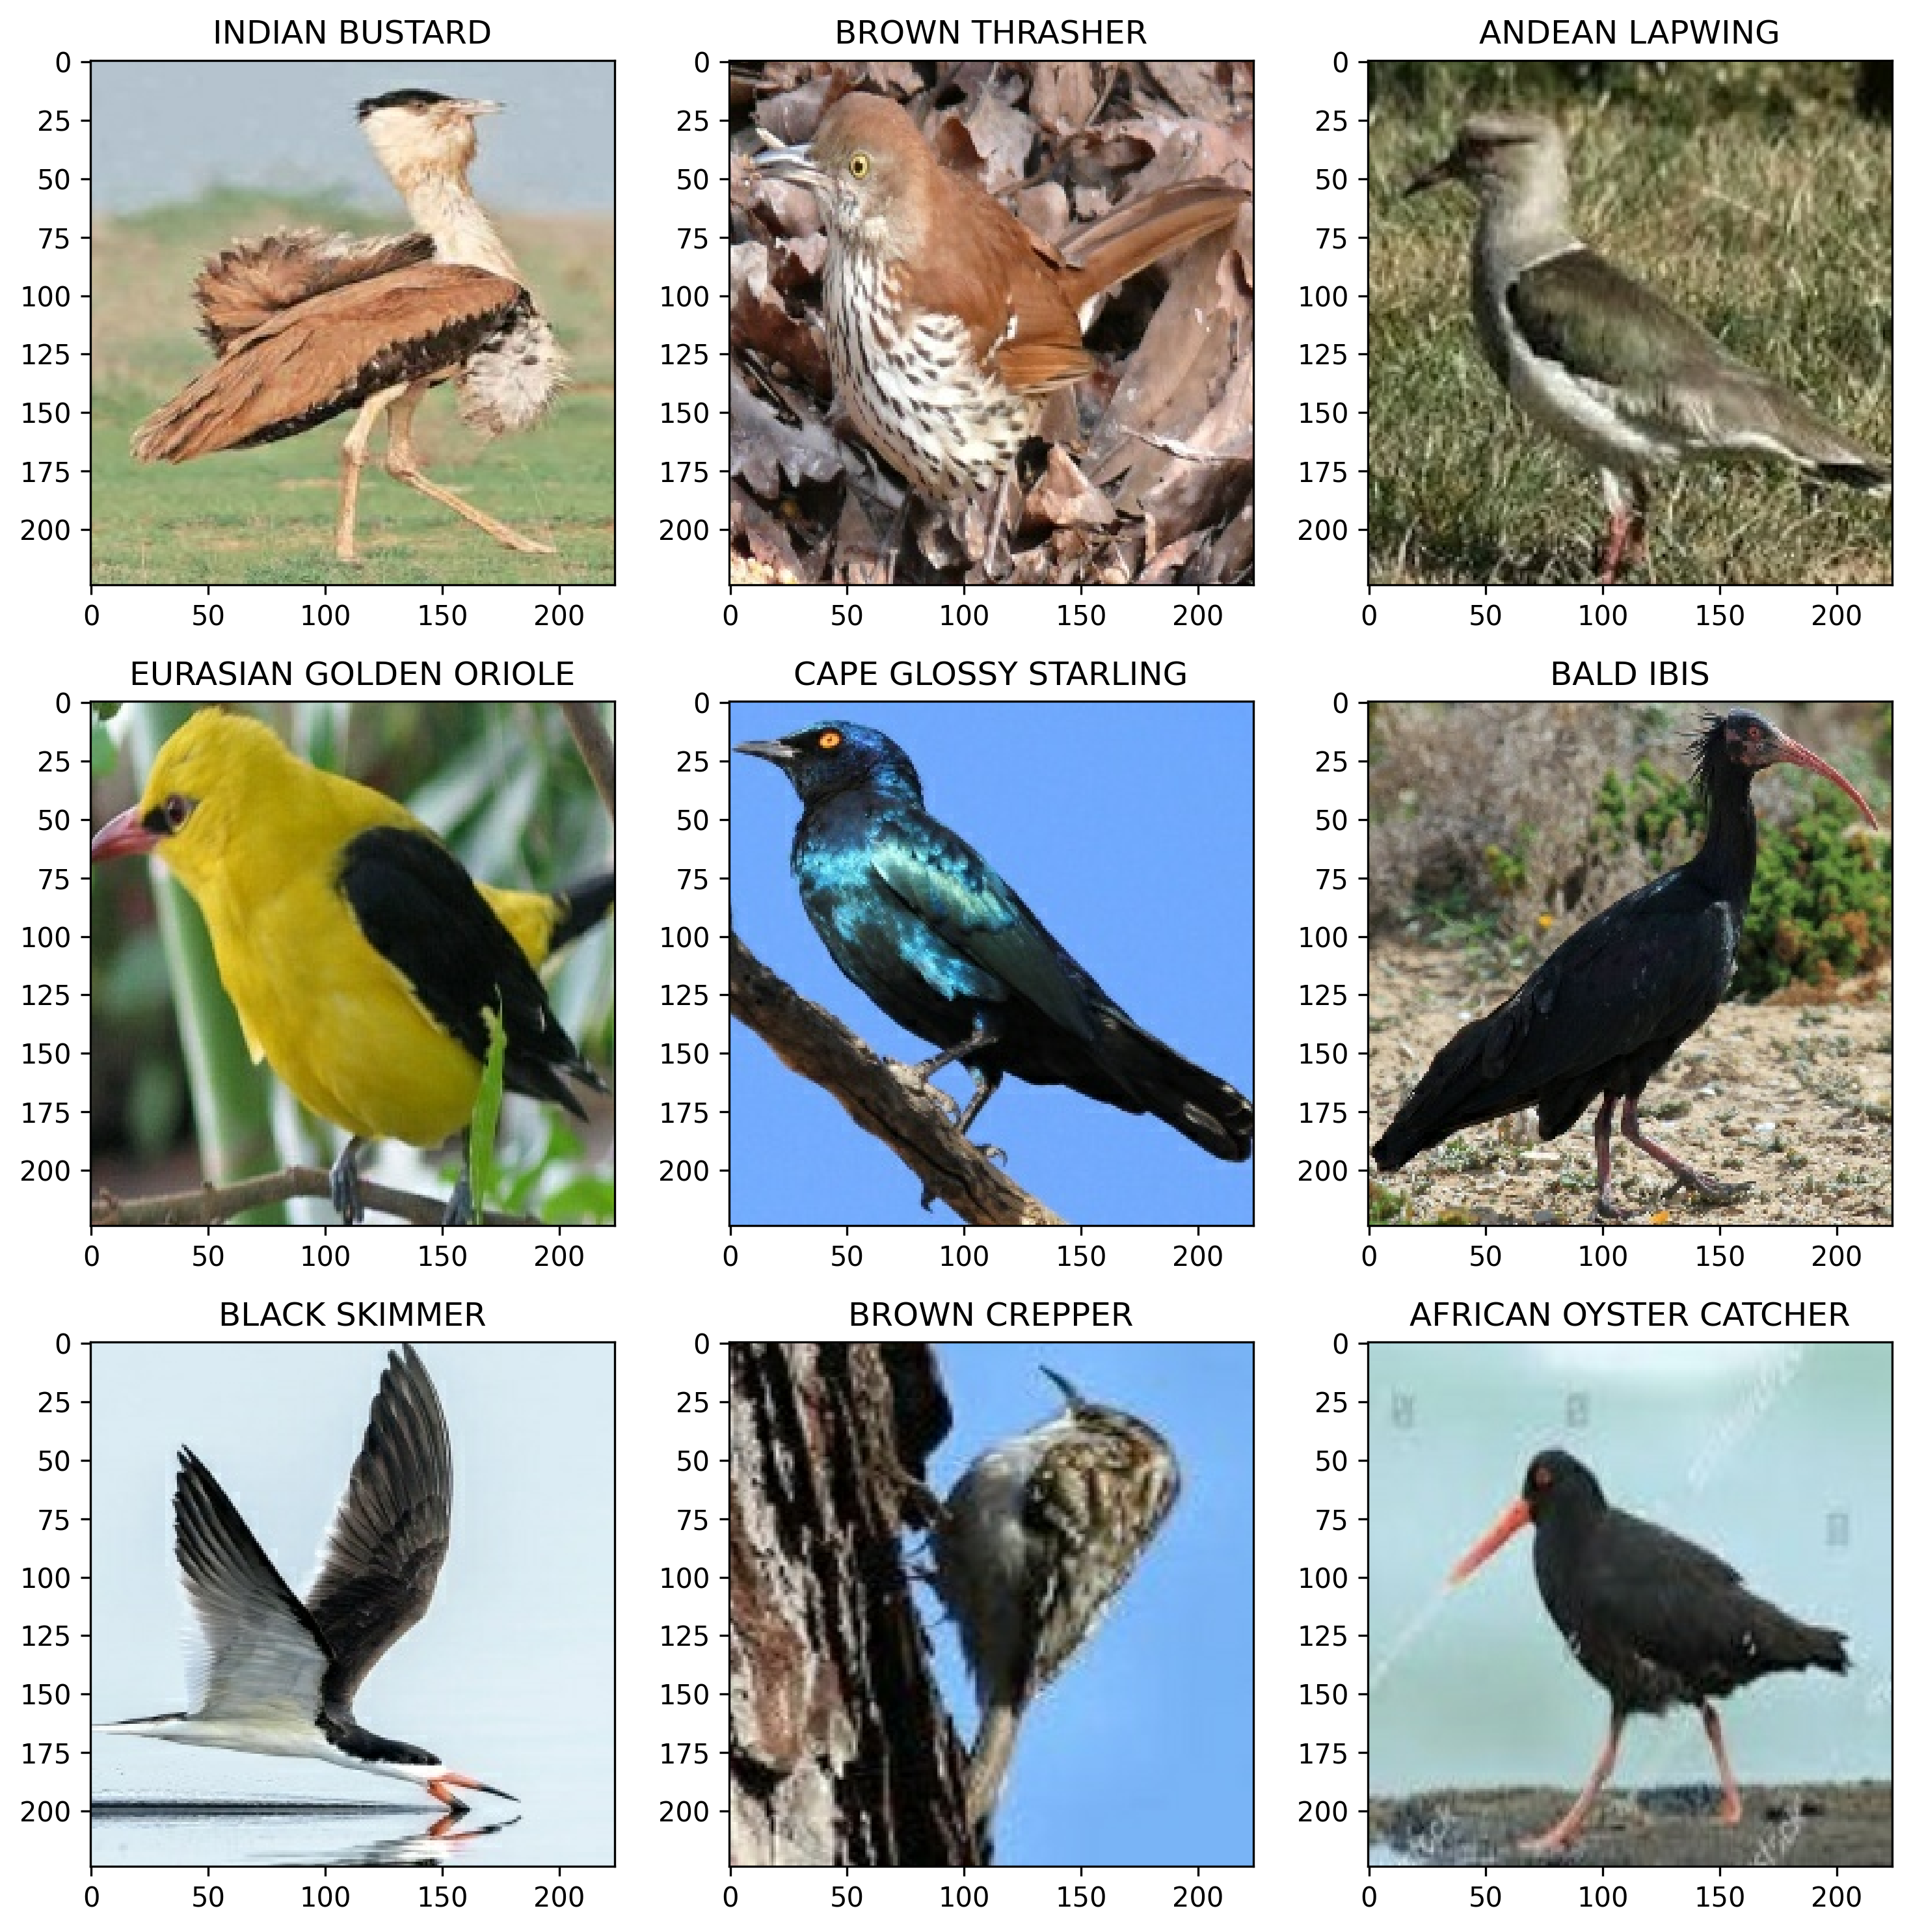

In [12]:
classes = train.class_names
plt.figure(figsize=(10, 10), dpi=300)
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        class_name = classes[labels[i]]
        plt.title(class_name)
plt.tight_layout()    
plt.show() 

### Construção dos modelos

In [13]:
classes = train.class_names
classes_length = len(classes)

#### Modelo base

In [19]:
#MobileNetV2
mnv2_base_model = keras.applications.MobileNetV2(input_shape=(Dataset.IMAGE_WIDTH, Dataset.IMAGE_HEIGHT, 3),
                                            include_top=False,
                                            weights='imagenet')
mnv2_base_model.trainable = False


#MobileNetV3Small
mnv3sm_base_model = keras.applications.MobileNetV3Small(input_shape=(Dataset.IMAGE_WIDTH, Dataset.IMAGE_HEIGHT, 3),
                                            include_top=False,
                                            weights='imagenet')
mnv3sm_base_model.trainable = False


#MobileNetV3Large
mnv3lg_base_model = keras.applications.MobileNetV3Large(input_shape=(Dataset.IMAGE_WIDTH, Dataset.IMAGE_HEIGHT, 3),
                                            include_top=False,
                                            weights='imagenet')
mnv3lg_base_model.trainable = False

#ResNet152V2
resnet_base_model = keras.applications.ResNet152V2(input_shape=(Dataset.IMAGE_WIDTH, Dataset.IMAGE_HEIGHT, 3),
                                            include_top=False,
                                            weights='imagenet')
resnet_base_model.trainable = False

#### MobileNetV2

In [20]:
inputs = keras.Input(shape=(Dataset.IMAGE_WIDTH, Dataset.IMAGE_HEIGHT, 3))
x = keras.applications.mobilenet_v2.preprocess_input(inputs)
x = mnv2_base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(classes_length, activation='softmax')(x)
mnv2_model = keras.Model(inputs, outputs)

mnv2_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
mnv2_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

#### MobileNetV3Small

In [16]:
inputs = keras.Input(shape=(Dataset.IMAGE_WIDTH, Dataset.IMAGE_HEIGHT, 3))
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = mnv3sm_base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(classes_length, activation='softmax')(x)
mnv3sm_model = keras.Model(inputs, outputs)

mnv3sm_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
mnv3sm_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 576)               0         
                                                                 
 dense_3 (Dense)             (None, 400)               230800    
                                                                 
Total params: 1,169,920
Trainable params: 230,800
Non-train

#### MobileNetV3Large

In [17]:
inputs = keras.Input(shape=(Dataset.IMAGE_WIDTH, Dataset.IMAGE_HEIGHT, 3))
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = mnv3lg_base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(classes_length, activation='softmax')(x)
mnv3lg_model = keras.Model(inputs, outputs)

mnv3lg_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
mnv3lg_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_4   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 960)               0         
                                                                 
 dense_4 (Dense)             (None, 400)               384400    
                                                                 
Total params: 3,380,752
Trainable params: 384,400
Non-train

#### ResNet 152v2

In [18]:
inputs = keras.Input(shape=(Dataset.IMAGE_WIDTH, Dataset.IMAGE_HEIGHT, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = resnet_base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(classes_length, activation='softmax')(x)
resnet_model = keras.Model(inputs, outputs)

resnet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
resnet_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

### Treinamento dos modelos

#### MobileNetV2

In [21]:
initial_epochs = 25

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

mnv2_history = mnv2_model.fit(train, 
                              validation_data=validation,
                              epochs=initial_epochs,
                              callbacks=[early_stop])

Epoch 1/25
1825/1825 [==============================] - 116s 62ms/step - loss: 1.2396 - accuracy: 0.7320 - val_loss: 0.3760 - val_accuracy: 0.9075
Epoch 2/25
1825/1825 [==============================] - 113s 62ms/step - loss: 0.4091 - accuracy: 0.8966 - val_loss: 0.2802 - val_accuracy: 0.9260
Epoch 3/25
1825/1825 [==============================] - 112s 61ms/step - loss: 0.2674 - accuracy: 0.9316 - val_loss: 0.2551 - val_accuracy: 0.9265
Epoch 4/25
1825/1825 [==============================] - 113s 62ms/step - loss: 0.1903 - accuracy: 0.9503 - val_loss: 0.2298 - val_accuracy: 0.9340
Epoch 5/25
1825/1825 [==============================] - 112s 61ms/step - loss: 0.1481 - accuracy: 0.9610 - val_loss: 0.2151 - val_accuracy: 0.9360
Epoch 6/25
1825/1825 [==============================] - 113s 62ms/step - loss: 0.1179 - accuracy: 0.9683 - val_loss: 0.2165 - val_accuracy: 0.9385


#### MobileNetV3Small

In [19]:
initial_epochs = 25

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

mnv3sm_history = mnv3sm_model.fit(train, 
                                  validation_data=validation,
                                  epochs=initial_epochs,
                                  callbacks=[early_stop])

Epoch 1/25
1825/1825 [==============================] - 62s 32ms/step - loss: 1.7550 - accuracy: 0.6677 - val_loss: 0.4802 - val_accuracy: 0.9085
Epoch 2/25
1825/1825 [==============================] - 59s 32ms/step - loss: 0.6064 - accuracy: 0.8653 - val_loss: 0.2849 - val_accuracy: 0.9450
Epoch 3/25
1825/1825 [==============================] - 58s 32ms/step - loss: 0.4428 - accuracy: 0.8948 - val_loss: 0.2304 - val_accuracy: 0.9495
Epoch 4/25
1825/1825 [==============================] - 58s 32ms/step - loss: 0.3595 - accuracy: 0.9123 - val_loss: 0.1990 - val_accuracy: 0.9550
Epoch 5/25
1825/1825 [==============================] - 59s 32ms/step - loss: 0.3058 - accuracy: 0.9222 - val_loss: 0.1891 - val_accuracy: 0.9550
Epoch 6/25
1825/1825 [==============================] - 58s 32ms/step - loss: 0.2685 - accuracy: 0.9297 - val_loss: 0.1764 - val_accuracy: 0.9550
Epoch 7/25
1825/1825 [==============================] - 60s 33ms/step - loss: 0.2438 - accuracy: 0.9346 - val_loss: 0.1714 -

#### MobileNetV3Large

In [20]:
initial_epochs = 25

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

mnv3lg_history = mnv3lg_model.fit(train, 
                                  validation_data=validation,
                                  epochs=initial_epochs,
                                  callbacks=[early_stop])

Epoch 1/25
1825/1825 [==============================] - 96s 51ms/step - loss: 1.0286 - accuracy: 0.7899 - val_loss: 0.2053 - val_accuracy: 0.9575
Epoch 2/25
1825/1825 [==============================] - 92s 50ms/step - loss: 0.2722 - accuracy: 0.9331 - val_loss: 0.1553 - val_accuracy: 0.9595
Epoch 3/25
1825/1825 [==============================] - 92s 50ms/step - loss: 0.1745 - accuracy: 0.9566 - val_loss: 0.1274 - val_accuracy: 0.9645
Epoch 4/25
1825/1825 [==============================] - 89s 49ms/step - loss: 0.1248 - accuracy: 0.9676 - val_loss: 0.1200 - val_accuracy: 0.9700
Epoch 5/25
1825/1825 [==============================] - 88s 48ms/step - loss: 0.0960 - accuracy: 0.9748 - val_loss: 0.1208 - val_accuracy: 0.9655


#### ResNet 152v2

In [21]:
initial_epochs = 25

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

resnet_history = resnet_model.fit(train, 
                                  validation_data=validation,
                                  epochs=initial_epochs,
                                  callbacks=[early_stop])

Epoch 1/25
1825/1825 [==============================] - 406s 219ms/step - loss: 1.1096 - accuracy: 0.7453 - val_loss: 0.3043 - val_accuracy: 0.9125
Epoch 2/25
1825/1825 [==============================] - 395s 216ms/step - loss: 0.3537 - accuracy: 0.9031 - val_loss: 0.2255 - val_accuracy: 0.9350
Epoch 3/25
1825/1825 [==============================] - 393s 216ms/step - loss: 0.2305 - accuracy: 0.9351 - val_loss: 0.2390 - val_accuracy: 0.9255


#### Salvando/carregando os modelos

In [8]:
mnv2_model = keras.models.load_model('birds-mobilenetv2.h5')
mnv3sm_model = keras.models.load_model('birds-mobilenetv3small.h5')
mnv3lg_model = keras.models.load_model('birds-mobilenetv3large.h5')
resnet_model = keras.models.load_model('birds-resnet.h5')

In [28]:
mnv2_model.save('birds-mobilenetv2.h5')
mnv3sm_model.save('birds-mobilenetv3small.h5')
mnv3lg_model.save('birds-mobilenetv3large.h5')
resnet_model.save('birds-resnet.h5')

### Avaliação dos resultados

In [22]:
mnv2_results = mnv2_model.evaluate(test)
mnv3sm_results = mnv3sm_model.evaluate(test)
mnv3lg_results = mnv3lg_model.evaluate(test)
resnet_results = resnet_model.evaluate(test)

63/63 [==============================] - 19s 303ms/step - loss: 0.1857 - accuracy: 0.9420


In [28]:
results_metrics = np.array([mnv2_results, mnv3sm_results, mnv3lg_results, resnet_results])
results_modelnames = ['MobileNetV2', 'MobileNetV3Small', 'MobileNetV3Large', 'ResNet152V2']
results_df = pd.DataFrame(data = results_metrics, 
                          index = results_modelnames, 
                          columns = mnv2_model.metrics_names)

print(results_df.sort_values('accuracy', ascending=False))

                      loss  accuracy
MobileNetV3Large  0.068799    0.9835
MobileNetV3Small  0.116991    0.9675
MobileNetV2       0.164640    0.9460
ResNet152V2       0.185694    0.9420


#### Função auxiliar para plotagem de gráficos

In [22]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8), dpi=300)
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

#### MobileNetV2

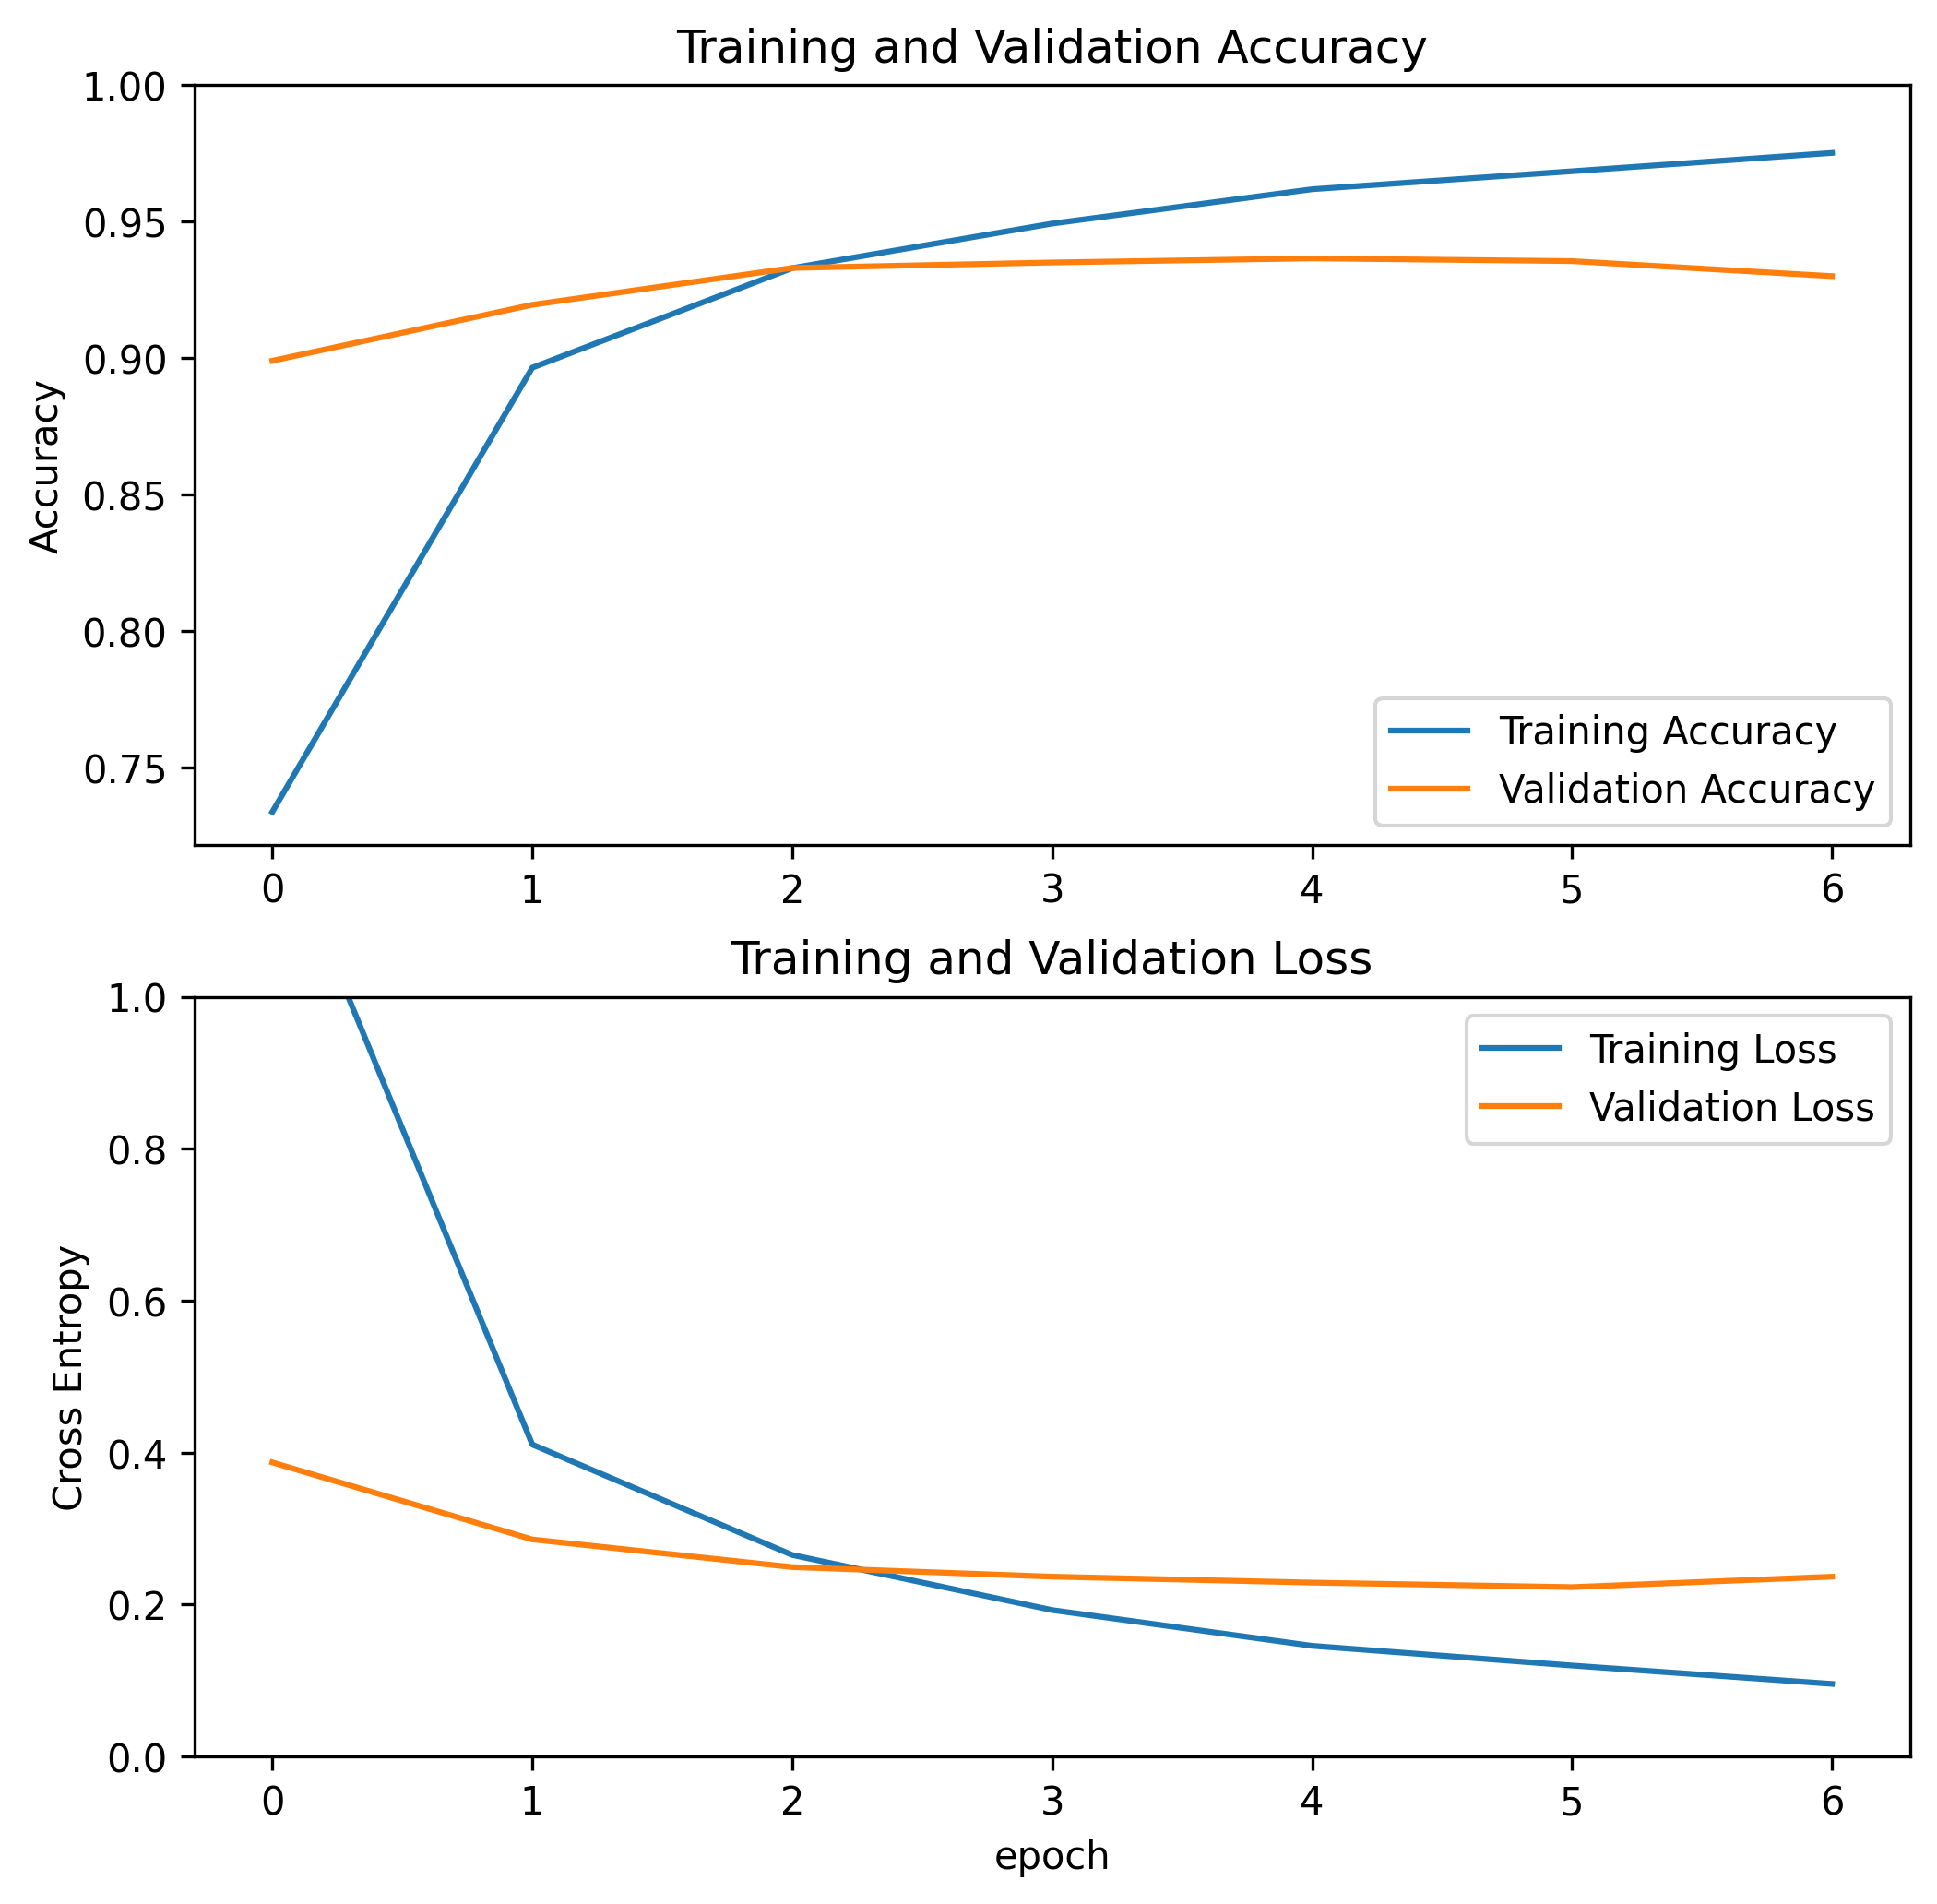

In [24]:
plot_history(mnv2_history)

#### MobileNetV3Small

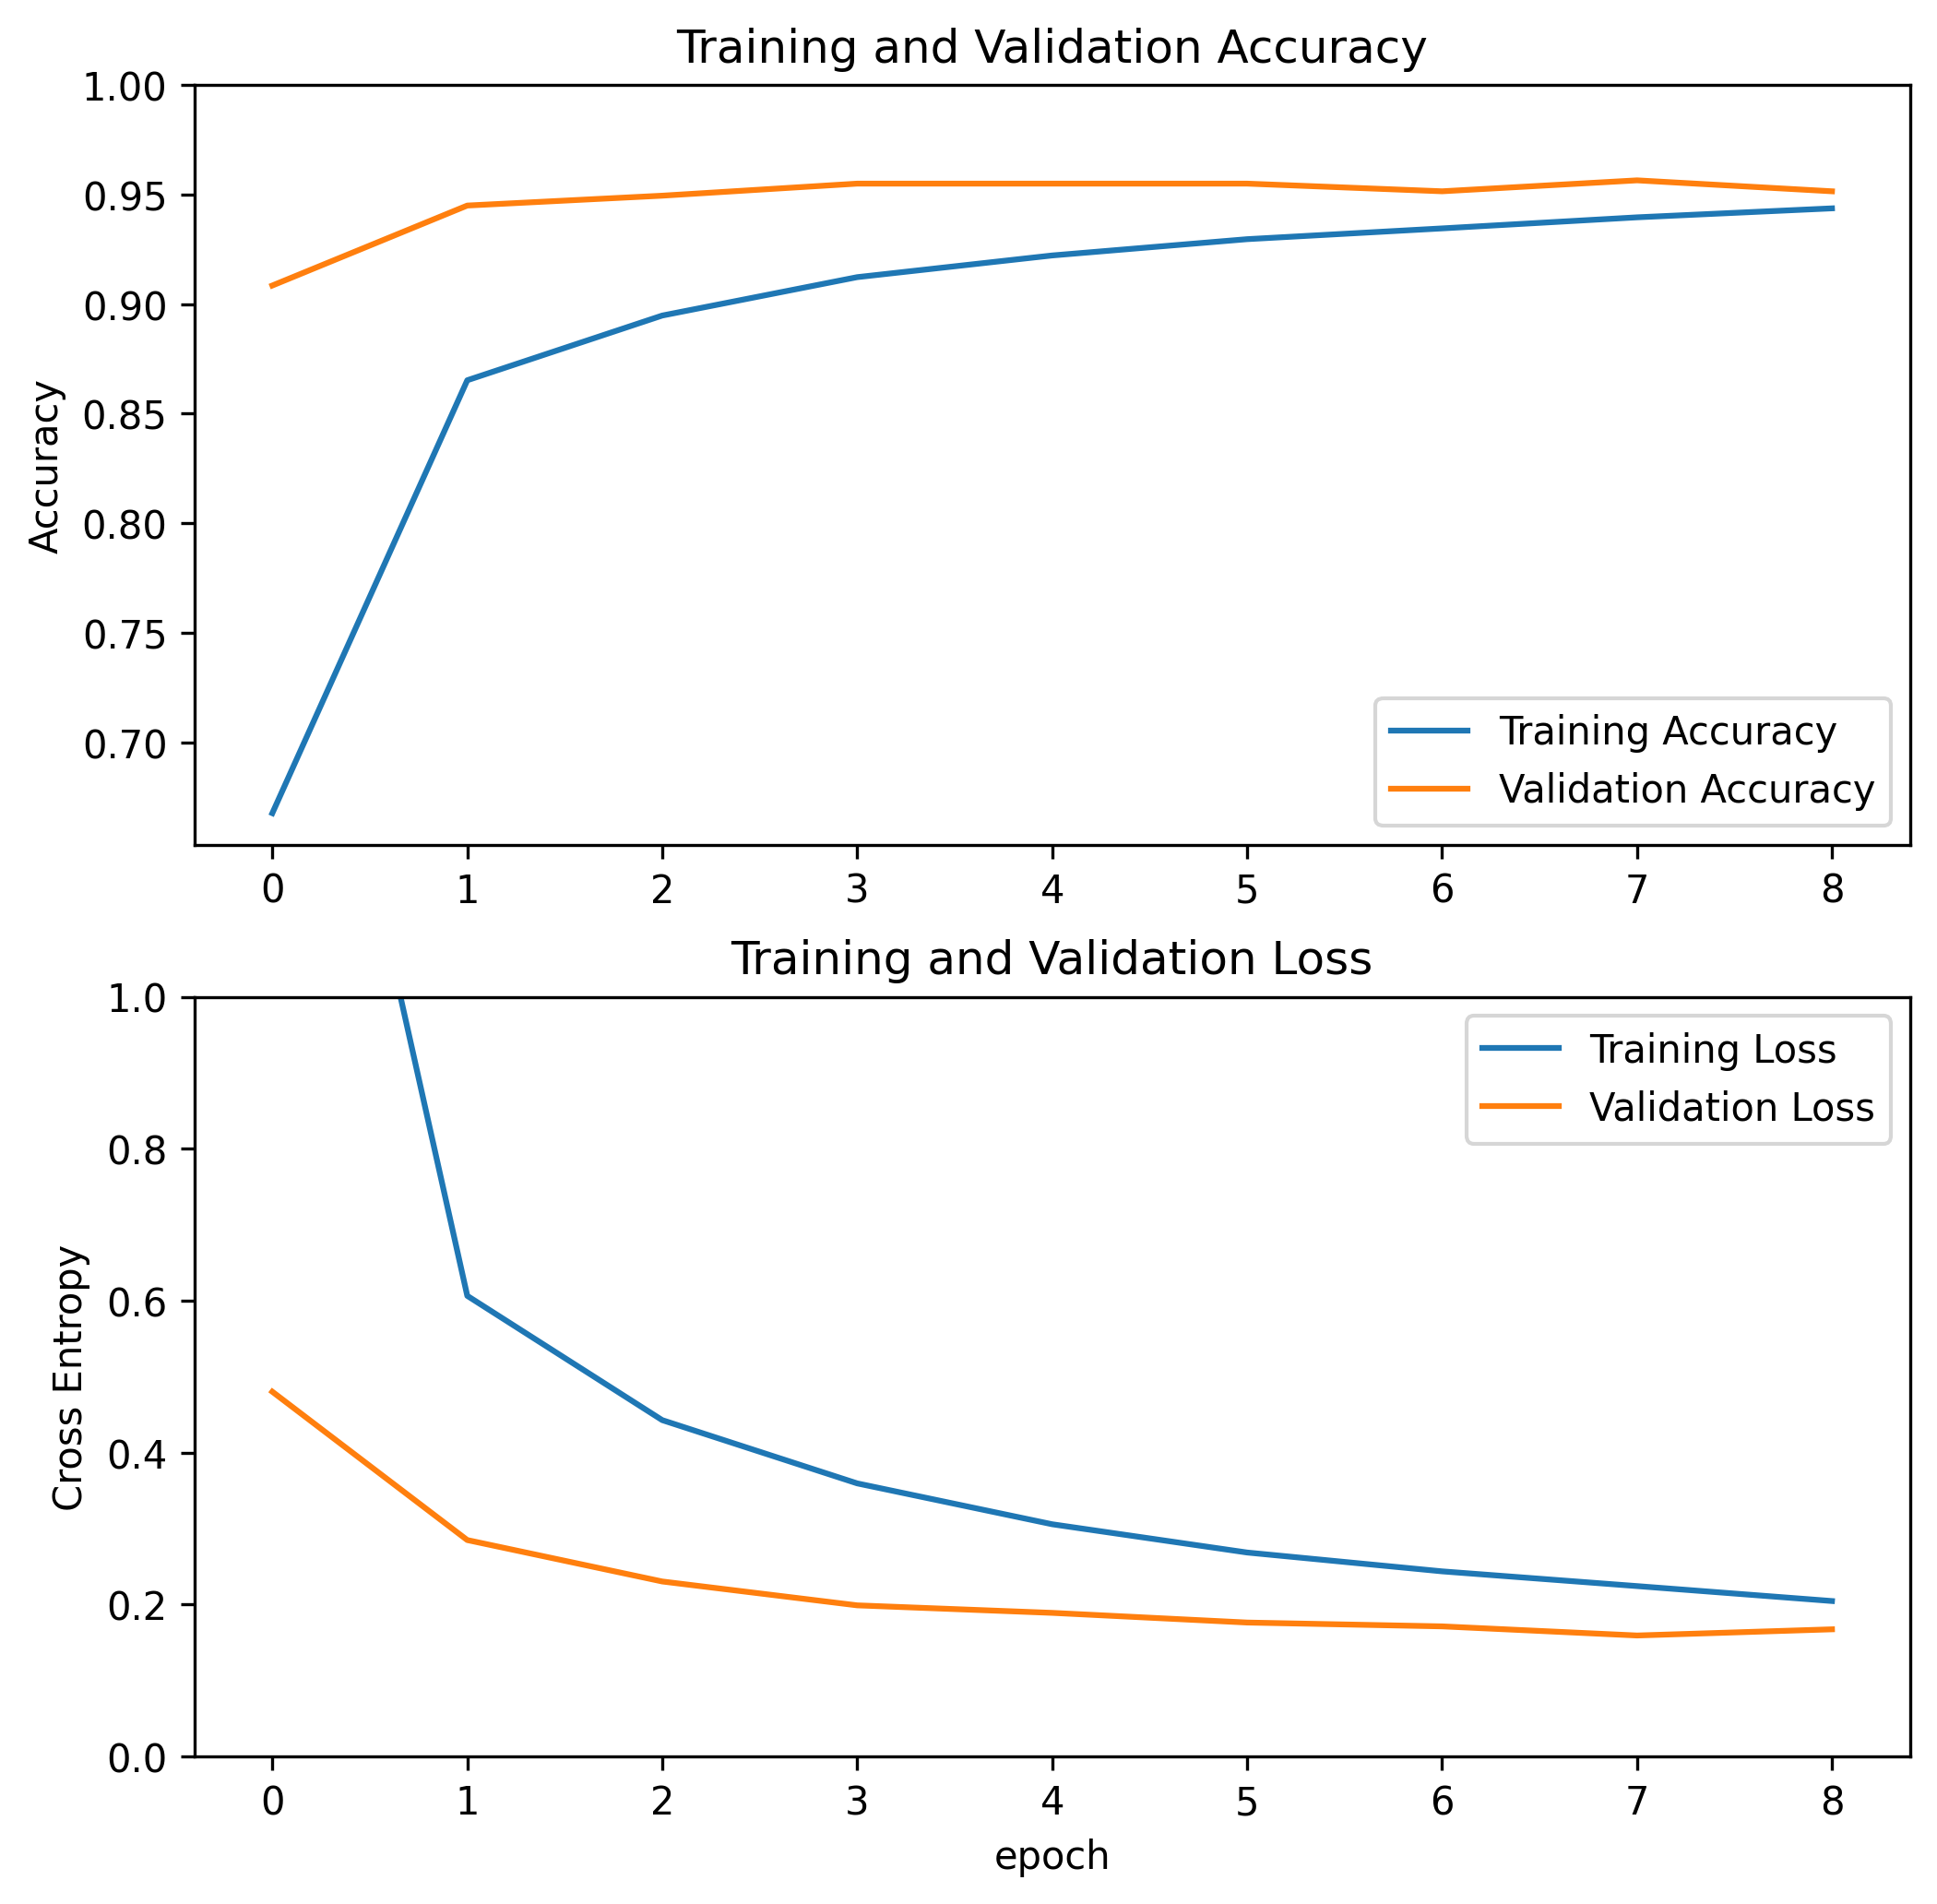

In [25]:
plot_history(mnv3sm_history)

#### MobileNetV3Large

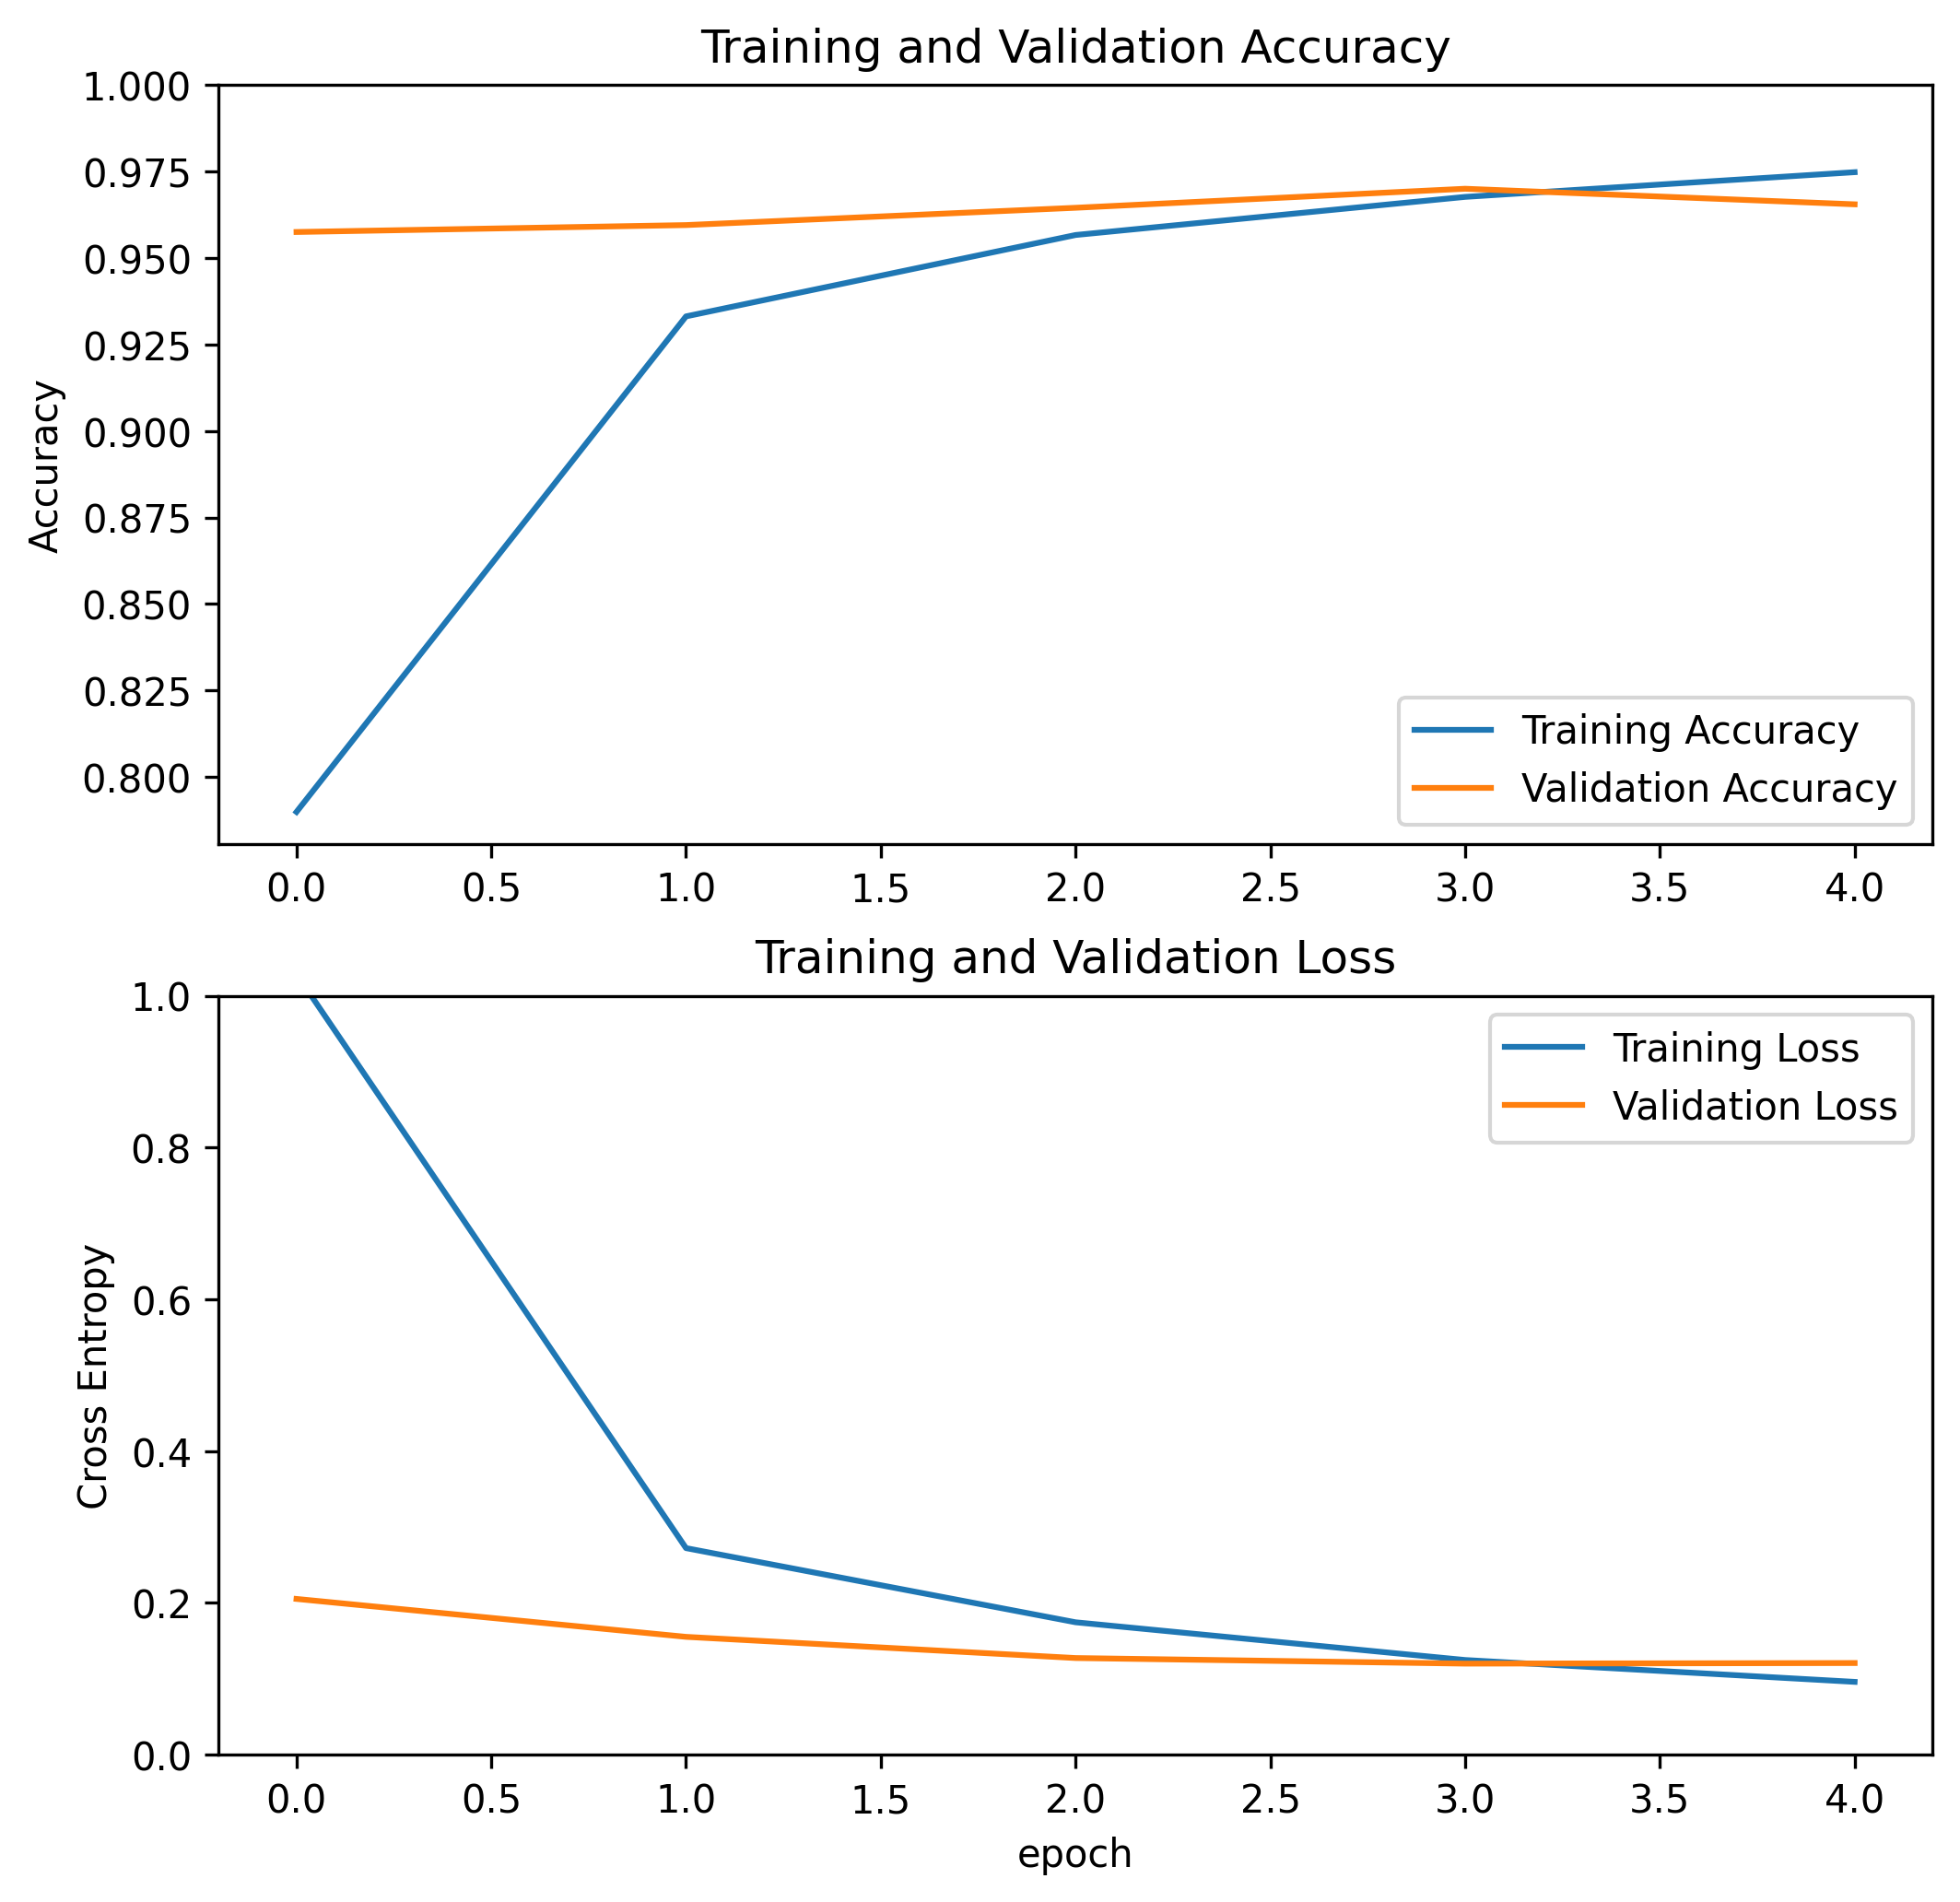

In [26]:
plot_history(mnv3lg_history)

#### ResNet 152v2

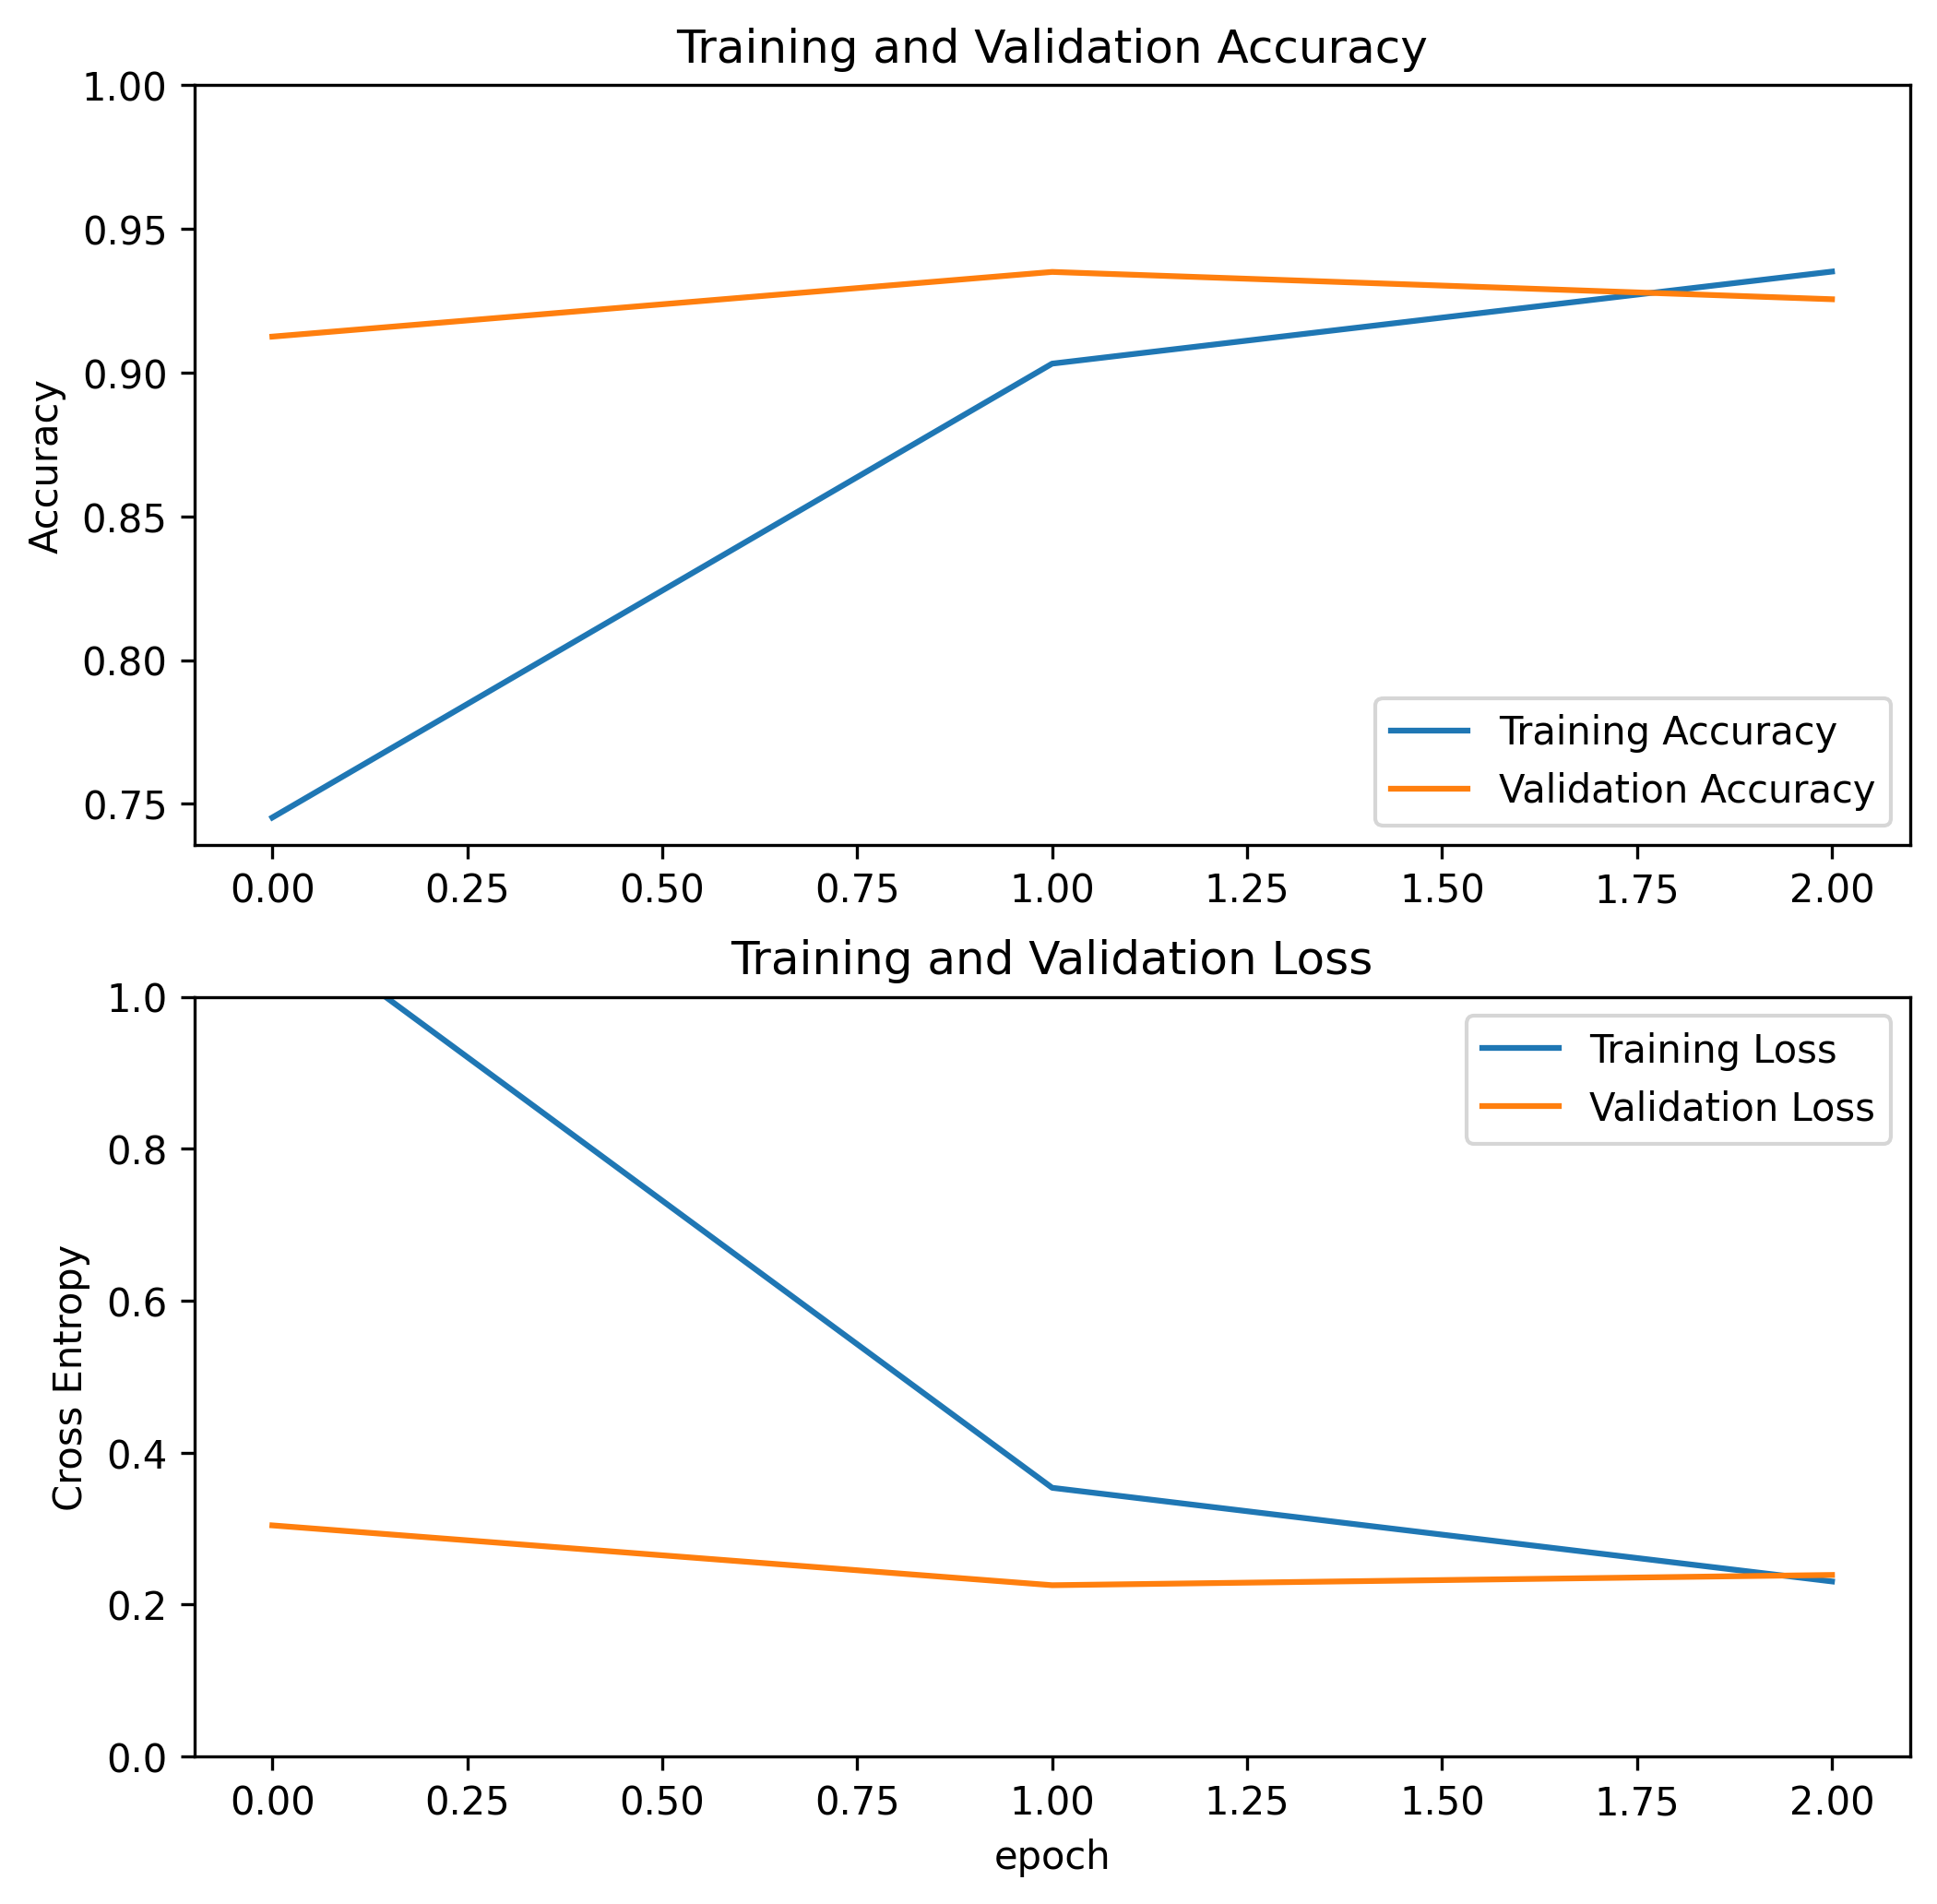

In [27]:
plot_history(resnet_history)